In [26]:
from __future__ import annotations
from qiskit import QuantumCircuit
from transpiler.qasm2_reader import load_qasm, from_qasm2_to_braket
from bqskit.ext import bqskit_to_qiskit,qiskit_to_bqskit
from qiskit_aer import AerSimulator
from qiskit import transpile
import pennylane as qml
import numpy as np
from braket.devices import LocalSimulator
from braket.circuits import Circuit as braket_Circuit
from transpiler.transpile import transpile_circuit as bqskit_transpiler
from transpiler.transpile import get_noisy_counts
from qiskit.circuit.random import random_circuit
from qiskit.transpiler import CouplingMap
from qiskit.circuit.quantumregister import Qubit, QuantumRegister
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict

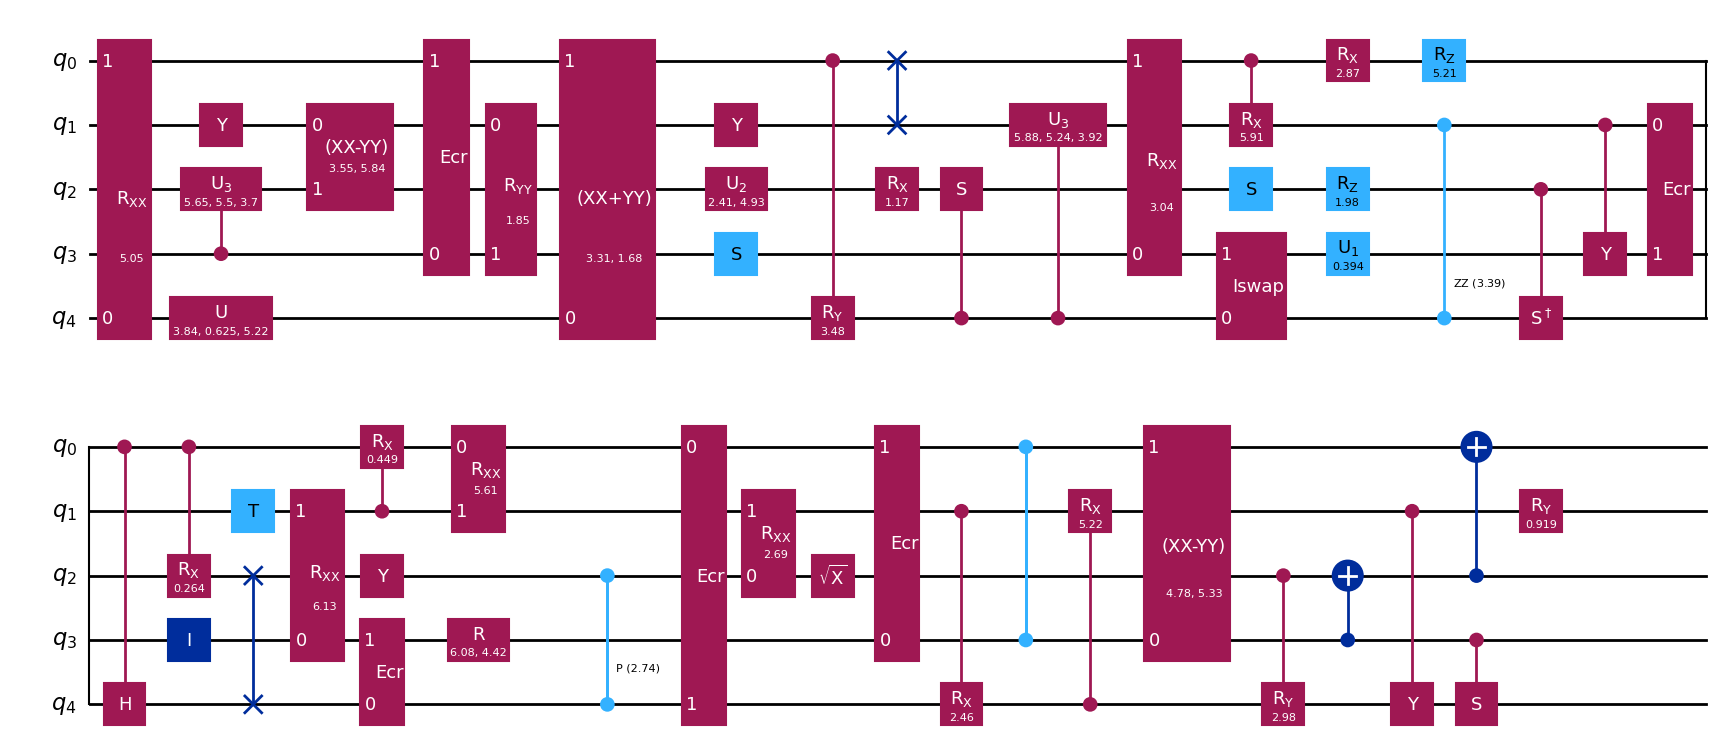

In [33]:
# Create a 4-qubit quantum circuit
# Generate a random 4-qubit circuit with a depth of 5
qc = random_circuit(5,max_operands=2, depth=20, measure=False)
qc_bqskit=qiskit_to_bqskit(qc)
qc.draw("mpl")

In [34]:
 # Initialize the latest AerSimulator
simulator = AerSimulator()

coupling_map = CouplingMap([
    (0, 1), (0, 3), (1, 4), (2, 3),
    (2, 7), (3, 4), (3, 8), (4, 5), (4, 9),
    (5, 6), (5, 10), (6, 11), (7, 8), (7, 12),
    (8, 9), (8, 13), (9, 10), (9, 14), (10, 11),
    (10, 15), (11, 16), (12, 13), (13, 14), (13, 17),
    (14, 15), (14, 18), (15, 19), (15, 16),
    (17, 18), (18, 19)
])
initial_layout=[8,9,10,14,4]
# Transpile the circuit for the simulator

print(qc.num_nonlocal_gates())
qc_qiskit = transpile(qc, simulator,optimization_level=3,basis_gates=['rx','ry','cz'],coupling_map=coupling_map,initial_layout=initial_layout)
print(qc_qiskit.num_nonlocal_gates())
def inverse_permutation(permutation):
    """Compute the inverse of a given permutation."""
    inverse = np.empty_like(permutation)
    inverse[permutation] = np.arange(len(permutation))
    return list(inverse)

inverse_layout=inverse_permutation(initial_layout + [i for i in range(20) if i not in initial_layout])
qc_qiskit = transpile(qc_qiskit,optimization_level=0,initial_layout=inverse_layout)


37
84


In [ ]:
qc_qiskit.num_qubits

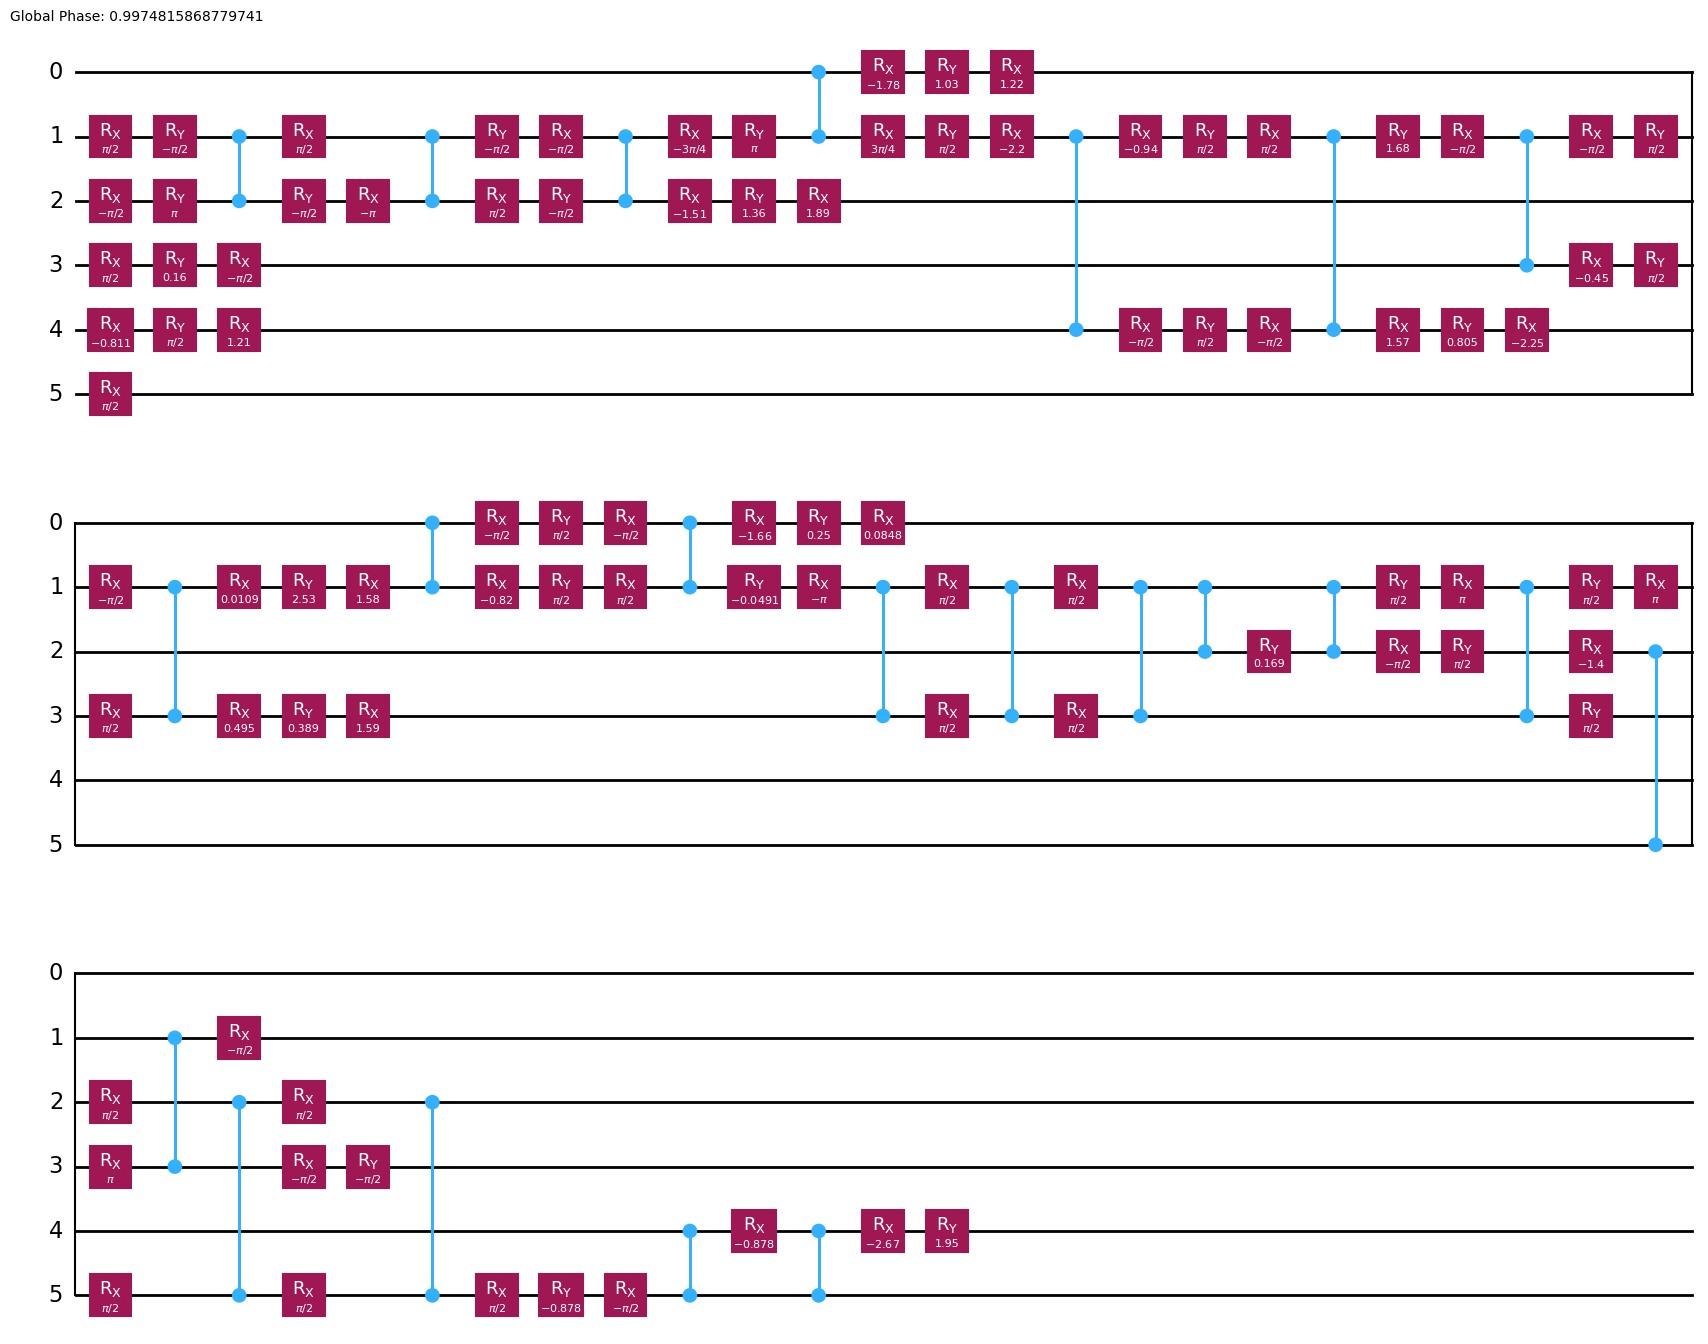

In [185]:
def remove_idle_qwires(circ):
    dag = circuit_to_dag(circ)

    idle_wires = list(dag.idle_wires())
    for w in idle_wires:
        dag._remove_idle_wire(w)
        dag.qubits.remove(w)

    dag.qregs = OrderedDict()

    return dag_to_circuit(dag)
remove_idle_qwires(qc_qiskit).draw()

qc_qiskit=remove_idle_qwires(qc_qiskit)
qc_qiskit.draw("mpl")
# qc_qiskit.draw()


In [186]:
get_noisy_counts(qc_qiskit,1000,0.00,0.000,0.00)

{'000000': 67,
 '000001': 30,
 '000010': 27,
 '000011': 43,
 '000100': 10,
 '000101': 14,
 '000110': 6,
 '000111': 8,
 '010000': 11,
 '010001': 8,
 '010010': 6,
 '010011': 8,
 '010100': 44,
 '010101': 52,
 '010110': 19,
 '010111': 36,
 '100000': 92,
 '100001': 51,
 '100010': 34,
 '100011': 51,
 '100100': 27,
 '100101': 24,
 '100110': 5,
 '100111': 27,
 '110000': 31,
 '110001': 18,
 '110010': 15,
 '110011': 24,
 '110100': 65,
 '110101': 67,
 '110110': 21,
 '110111': 59}

In [6]:
# Step 3: Transpile the circuit to MS gates
qc_qiskit_transpiled = bqskit_transpiler(qc_qiskit,device="Aria",optimization_level=2,synthesis_epsilon=1e-4)
print(qc_qiskit_transpiled)

CRITICAL:bqskit.compiler.compiler:Compiler interrupted.


KeyboardInterrupt: 

In [4]:
qml_circuit = qml.from_qiskit(qc_qiskit_transpiled)
print("Transpiled result",np.round(np.abs(qml.matrix(qml_circuit, wire_order=list(range(qc_qiskit.num_qubits)))().T[0])**2,5))


Transpiled result [9.9986e-01 0.0000e+00 7.0000e-05 0.0000e+00 7.0000e-05 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]


In [5]:
# print("Noise 0     simulation result:", get_noisy_counts(qc_qiskit_transpiled,0.00,0.000,0.00))
# print("Noiseless simulation result:",np.abs(qml.matrix(qml_circuit, wire_order=list(range(qc_qiskit.num_qubits)))().T[0])**2)
print("Noisy     simulation result:", get_noisy_counts(qc_qiskit_transpiled,0,0.00,0.000,0.00))#check
print("Noisy     simulation result2:", get_noisy_counts(qc_qiskit,0,0.00,0.000,0.00))#check

Noisy     simulation result: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Noisy     simulation result2: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
print("Noisy     simulation result:", get_noisy_counts(qc,0,0.00,0.000,0.00))#check
print("Noisy     simulation result2:", get_noisy_counts(qc_qiskit,0,0.00,0.000,0.00))#check

ValueError: Unknown gate Adjoint(T) encountered. Please check the circuit.

# IQM

In [10]:
from qiskit import QuantumCircuit
from braket.circuits import Circuit
import numpy as np

from qiskit import QuantumCircuit
from braket.circuits import Circuit
import numpy as np

def qiskit_to_braket(qc: QuantumCircuit) -> Circuit:
    """
    Convert a Qiskit QuantumCircuit to an Amazon Braket Circuit.

    This function translates Qiskit gates into their corresponding Braket equivalents,
    specifically targeting **IQM quantum devices**. 

    IQM devices support a **native gate set** that includes:
    - `prx(theta, alpha)`: Parameterized RX rotation (angle θ, axis shift α)
    - `cz`: Controlled-Z (CZ) gate

    Any additional gates are decomposed or mapped to this native set.

    Args:
        qc (QuantumCircuit): A Qiskit quantum circuit.

    Returns:
        Circuit: An Amazon Braket quantum circuit compatible with IQM devices.
    """

    braket_circuit = Circuit()  # Initialize an empty Braket circuit
    num_qubits = qc.num_qubits  # Get the number of qubits in the Qiskit circuit

    # Mapping of Qiskit gates to IQM's native Braket gates
    gate_map = {
        "h": lambda q, p: braket_circuit.h(q[0]),  # Hadamard gate
        "x": lambda q, p: braket_circuit.x(q[0]),  # Pauli-X gate
        "y": lambda q, p: braket_circuit.y(q[0]),  # Pauli-Y gate
        "z": lambda q, p: braket_circuit.z(q[0]),  # Pauli-Z gate

        # IQM-native RX (PRX) gate: prx(theta, alpha) with axis shift α
        "rx": lambda q, p: braket_circuit.prx(q[0], p[0], 0),  # RX(θ) with α=0
        "ry": lambda q, p: braket_circuit.prx(q[0], p[0], np.pi / 2),  # RY(θ) as RX(θ, π/2)
        "rz": lambda q, p: braket_circuit.rz(q[0], p[0]),  # RZ(θ) (directly supported)

        # Multi-qubit gates
        "cx": lambda q, p: braket_circuit.cnot(q[0], q[1]),  # CNOT (CX) gate
        "cz": lambda q, p: braket_circuit.cz(q[0], q[1]),  # **IQM-native CZ gate**
        "swap": lambda q, p: braket_circuit.swap(q[0], q[1]),  # SWAP gate
        "ccx": lambda q, p: braket_circuit.ccnot(q[0], q[1], q[2]),  # Toffoli (CCX) gate
    }

    # Iterate over Qiskit's circuit operations and convert them
    for instruction in qc.data:
        instr = instruction.operation  # Extract gate operation
        qargs = instruction.qubits     # Get the qubits involved in the operation
        qubits = [qc.find_bit(q).index for q in qargs]  # Extract qubit indices
        params = instr.params  # Get gate parameters (if any)

        if instr.name in gate_map:
            gate_map[instr.name](qubits, params)  # Apply the corresponding Braket gate
        else:
            raise ValueError(f"Unsupported gate: {instr.name}")  # Handle unsupported gates

    # Wrap the Braket circuit in a verbatim box and add measurement
    return Circuit().add_verbatim_box(braket_circuit).measure(range(num_qubits))


# Example usage
qc = QuantumCircuit(3)
qc.rx(1, 1)
qc.ry(0, 1)
qc.cz(0,2)


braket_circuit = qiskit_to_braket(qc)
print(braket_circuit)


T  : │        0        │          1           │         2         │       3       │  4  │
                                                                                   ┌───┐ 
q0 : ───StartVerbatim──────────────────────●─────────────────────────EndVerbatim───┤ M ├─
              ║                            │                              ║        └───┘ 
              ║         ┌──────────────┐   │   ┌─────────────────┐        ║        ┌───┐ 
q1 : ─────────║─────────┤ PRx(1.00, 0) ├───┼───┤ PRx(0.00, 1.57) ├────────║────────┤ M ├─
              ║         └──────────────┘   │   └─────────────────┘        ║        └───┘ 
              ║                          ┌─┴─┐                            ║        ┌───┐ 
q2 : ─────────╨──────────────────────────┤ Z ├────────────────────────────╨────────┤ M ├─
                                         └───┘                                     └───┘ 
T  : │        0        │          1           │         2         │       3       │  4  │


In [8]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from braket.circuits import Circuit
from braket.devices import LocalSimulator

def qiskit_to_braket(qc: QuantumCircuit) -> Circuit:
    """
    Convert a Qiskit QuantumCircuit to an Amazon Braket Circuit (IQM device).
    """
    braket_circuit = Circuit()
    gate_map = {
        "rx": lambda q, p: braket_circuit.prx(q[0], p[0], 0),
        "ry": lambda q, p: braket_circuit.prx(q[0], p[0], np.pi / 2),
        "cz": lambda q, p: braket_circuit.cz(q[0], q[1]),
        "measure": lambda q, p: braket_circuit.measure(q[0])
    }

    for instruction in qc.data:
        instr = instruction.operation
        qubits = [qc.find_bit(q).index for q in instruction.qubits]
        params = instr.params

        if instr.name == "barrier":
            continue  # Ignore barriers as they are not necessary for execution
        elif instr.name in gate_map:
            gate_map[instr.name](qubits, params)
        else:
            raise ValueError(f"Unsupported gate: {instr.name}")

    return braket_circuit

# Define a Qiskit test circuit with 10 gates
num_qubits = 3
qc = QuantumCircuit(num_qubits)
angles = np.random.uniform(0, 2*np.pi, size=7)
qc.ry(angles[0], 0)
qc.rx(angles[1], 1)
qc.cz(0, 1)
qc.ry(angles[2], 2)
qc.rx(angles[3], 0)
qc.cz(1, 2)
qc.ry(angles[4], 1)
qc.rx(angles[5], 2)
qc.cz(0, 2)
qc.ry(angles[6], 0)

# Add measurement to Qiskit circuit
qc.measure_all()

# Convert to Braket circuit
braket_circuit = qiskit_to_braket(qc)

# Initialize Braket local simulator
braket_device = LocalSimulator()
shots = 100000  # Number of shots

# Execute the Braket circuit
braket_task = braket_device.run(braket_circuit, shots=shots)
braket_result = braket_task.result()
braket_counts = braket_result.measurement_counts

# Simulate Qiskit circuit using AerSimulator
qiskit_backend = AerSimulator()
qiskit_job = qiskit_backend.run(qc, shots=shots)
qiskit_result = qiskit_job.result()
qiskit_counts = qiskit_result.get_counts()

# Display results
braket_counts, qiskit_counts


(Counter({'000': 34307,
          '001': 28670,
          '100': 18878,
          '101': 9541,
          '010': 4576,
          '110': 2099,
          '011': 1491,
          '111': 438}),
 {'000': 34281,
  '100': 28423,
  '001': 18954,
  '101': 9703,
  '010': 4610,
  '011': 2125,
  '110': 1502,
  '111': 402})

In [9]:
print(braket_circuit)

T  : │         0         │  1  │       2        │         3         │  4  │         5         │  6  │
      ┌─────────────────┐       ┌──────────────┐                           ┌─────────────────┐ ┌───┐ 
q0 : ─┤ PRx(3.29, 1.57) ├───●───┤ PRx(0.99, 0) ├───────────────────────●───┤ PRx(2.40, 1.57) ├─┤ M ├─
      └─────────────────┘   │   └──────────────┘                       │   └─────────────────┘ └───┘ 
       ┌──────────────┐   ┌─┴─┐                  ┌─────────────────┐   │                       ┌───┐ 
q1 : ──┤ PRx(3.28, 0) ├───┤ Z ├────────●─────────┤ PRx(3.72, 1.57) ├───┼───────────────────────┤ M ├─
       └──────────────┘   └───┘        │         └─────────────────┘   │                       └───┘ 
      ┌─────────────────┐            ┌─┴─┐        ┌──────────────┐   ┌─┴─┐                     ┌───┐ 
q2 : ─┤ PRx(5.22, 1.57) ├────────────┤ Z ├────────┤ PRx(1.15, 0) ├───┤ Z ├─────────────────────┤ M ├─
      └─────────────────┘            └───┘        └──────────────┘   └───┘        